In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from nflows import flows, transforms, distributions

from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism
from src.dimension_reduction.principal_geodesic_analysis.vector.l2_tangent_space_pca import l2TangentSpacePCAVectorSolver
from src.manifolds.euclidean.vector.pullback.standard import StandardPullbackVectorEuclidean
from src.manifolds.isometrized_euclidean.vector import l2IsometrizedVectorEuclidean
from src.multimodal.sum_of_diagonal_gaussian import SumOfDiagonalGaussian
from src.transforms.parity.tanh import TanhParityTransform
from src.transforms.householder_linear import HouseholderLinearTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(31)

### Learning Geometry ###

/Users/wdiepeveen/Documents/Postdoc/projects/2 - Riemannian geometry-based fairness in data science/src/iso-Riemannian-geometry/.venv/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


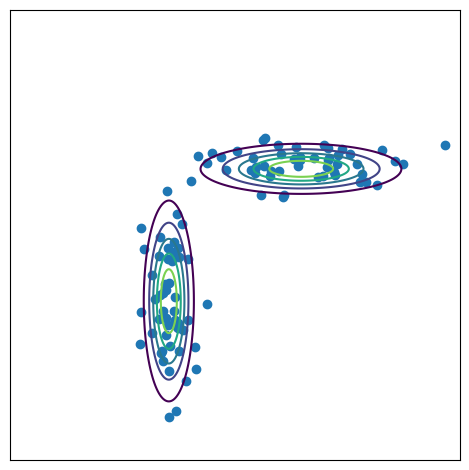

In [2]:
# Construct dataset
def multi_modal_gaussian_sampling(model, num_samples):
    def divide_number(n):
        if n % 2 == 0:
            # If the number is even, divide it equally
            return n // 2, n // 2
        else:
            # If the number is odd, make the first part one higher
            return (n + 1) // 2, (n - 1) // 2
        
    A_size, B_size = divide_number(num_samples)

    data_A = model.psi[0].offset[None] + 1 / torch.sqrt(model.psi[0].inverse_diagonal)[None] * torch.randn(A_size, 2)
    data_B = model.psi[1].offset[None] + 1 / torch.sqrt(model.psi[1].inverse_diagonal)[None] * torch.randn(B_size, 2)

    data = torch.cat([data_A, data_B], 0)

    # Generate random permutation of indices
    perm = torch.randperm(num_samples)

    # Shuffle the data tensor along the 0th axis
    return data[perm]

num_samples = 100
offset, a1, a2, w1, w2 = 5., 1/4, 4, 1, 1
double_gaussian = SumOfDiagonalGaussian(torch.tensor([[a1, a2], [a2, a1]]), torch.tensor([[-offset, 0.], [0., offset]]), torch.tensor([w1, w2]))

data_train = multi_modal_gaussian_sampling(double_gaussian, num_samples)
mean = data_train.mean(0)
data_train -= mean[None]
norm = data_train.norm(2,1).max()
data_train /= norm

train_loader = DataLoader(data_train, batch_size=16, shuffle=False)

# plot data
offset = 5

xx = torch.linspace(-6.0 - offset, 6.0, 500)
yy = torch.linspace(-6.0, 6.0 + offset, 500)
x_grid, y_grid = torch.meshgrid(xx, yy)

xy_grid = torch.zeros((*x_grid.shape,2))
xy_grid[:,:,0] = x_grid
xy_grid[:,:,1] = y_grid

density = torch.exp(double_gaussian.log_density(xy_grid.reshape(-1,2)).reshape(x_grid.shape))
levels = torch.linspace(density.min(), density.max(), 7)  # Adjust the number of levels as needed        # Retrieve the automatically generated levels
new_levels = levels[1:]    

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data_train[:,0], data_train[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.show()

In [3]:
# Define the normalizing flow model
def create_flow_model(dim, n_flows, n_hoho, order):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for i in range(n_flows):
        transforms_list.append(transforms.normalization.ActNorm(features=dim))
        for k in range(n_hoho):
            transforms_list.append(HouseholderLinearTransform(dim))
        transforms_list.append(TanhParityTransform(dim, order, parity=i%2))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return flows.Flow(transform=flow_transforms, distribution=base_dist)

In [4]:
# Initialize the model
dim = 2
n_flows = 2
n_hoho = 2
order = 2
model = create_flow_model(dim, n_flows, n_hoho, order).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.2)

In [5]:
# Training loop
def train(model, train_loader, optimizer, n_epochs):
    for epoch in range(n_epochs):
        for batch_idx, x in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Compute loss
            loss = -model.log_prob(x).mean()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

In [6]:
# Train the model
n_epochs = 500
train(model, train_loader, optimizer, n_epochs)

Epoch 1/500, Loss: 0.3060
Epoch 2/500, Loss: 0.3012
Epoch 3/500, Loss: 0.2919
Epoch 4/500, Loss: 0.2770
Epoch 5/500, Loss: 0.2593
Epoch 6/500, Loss: 0.2420
Epoch 7/500, Loss: 0.2268
Epoch 8/500, Loss: 0.2144
Epoch 9/500, Loss: 0.2043
Epoch 10/500, Loss: 0.1959
Epoch 11/500, Loss: 0.1884
Epoch 12/500, Loss: 0.1814
Epoch 13/500, Loss: 0.1747
Epoch 14/500, Loss: 0.1683
Epoch 15/500, Loss: 0.1624
Epoch 16/500, Loss: 0.1570
Epoch 17/500, Loss: 0.1520
Epoch 18/500, Loss: 0.1474
Epoch 19/500, Loss: 0.1431
Epoch 20/500, Loss: 0.1391
Epoch 21/500, Loss: 0.1353
Epoch 22/500, Loss: 0.1317
Epoch 23/500, Loss: 0.1283
Epoch 24/500, Loss: 0.1251
Epoch 25/500, Loss: 0.1220
Epoch 26/500, Loss: 0.1192
Epoch 27/500, Loss: 0.1164
Epoch 28/500, Loss: 0.1137
Epoch 29/500, Loss: 0.1112
Epoch 30/500, Loss: 0.1088
Epoch 31/500, Loss: 0.1064
Epoch 32/500, Loss: 0.1042
Epoch 33/500, Loss: 0.1020
Epoch 34/500, Loss: 0.0999
Epoch 35/500, Loss: 0.0979
Epoch 36/500, Loss: 0.0959
Epoch 37/500, Loss: 0.0940
Epoch 38/5

In [7]:
# Generate samples
@torch.no_grad()
def generate_samples(model, n_samples):
    samples = model.sample(n_samples).cpu()
    return samples

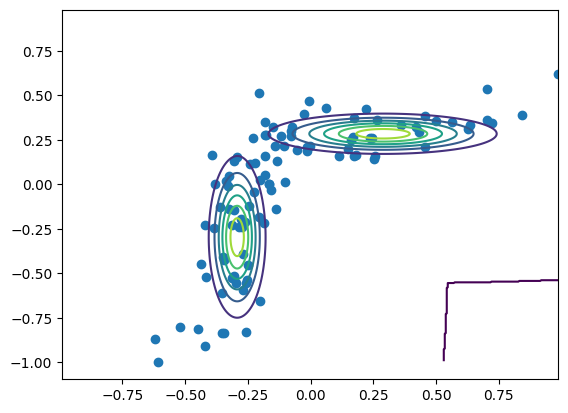

In [8]:
# Visualize generated samples
samples = generate_samples(model, 100)

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density)
plt.scatter(samples[:,0], samples[:,1])
plt.show()

In [9]:
# Construct diffeomorphism
phi = NFlowVectorDiffeomorphism(2, model)

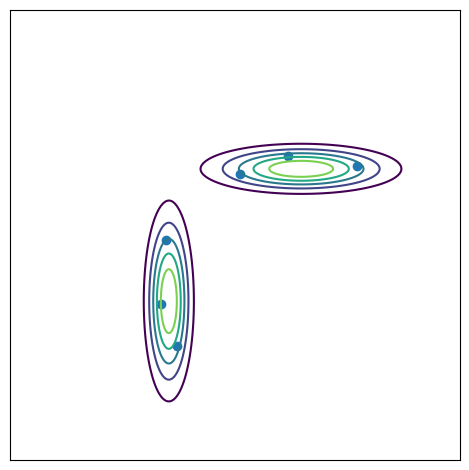

In [10]:
# special points
x0 = (torch.tensor([0.3 - offset,-1.7]) - mean)/norm
x1 = (torch.tensor([-0.3 - offset,-0.1]) - mean)/norm
x2 = (torch.tensor([-0.1 - offset,2.3]) - mean)/norm

y0 = (torch.tensor([-2.3,-0.2 + offset]) - mean)/norm
y1 = (torch.tensor([-0.5,0.5 + offset]) - mean)/norm
y2 = (torch.tensor([2.1,0.1 + offset]) - mean)/norm

data = torch.cat([x0[None], x1[None], x2[None], y0[None], y1[None], y2[None]],0)

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/data.eps")
plt.show()

### Naive Riemannian data analysis ###

In [11]:
# Construct pullback manifold
manifold = StandardPullbackVectorEuclidean(phi)

In [12]:
# compute geodesic
t = torch.linspace(0.,1.,20)

geodesic = manifold.geodesic(x0,y2,t).detach()

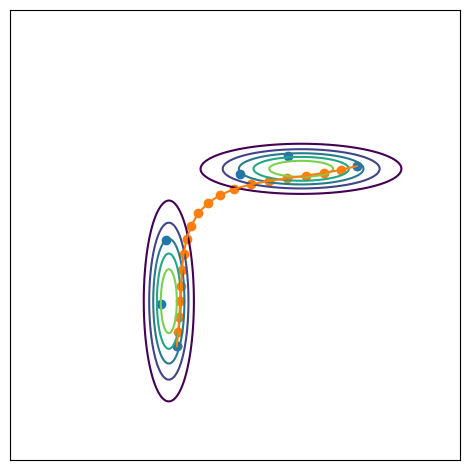

In [13]:
# plot geodesics
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.plot(geodesic[:,0], geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(geodesic[:,0], geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(data[:,0], data[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/geodesic.eps")
plt.show()

In [14]:
# compute barycentre
bary = manifold.barycentre(data.to(device)).detach().cpu()

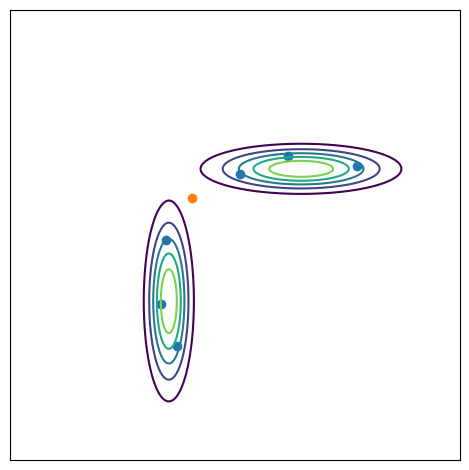

In [15]:
# plot barycentres
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/barycentre.eps")
plt.show()

In [16]:
# construct l2-pga solver
l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data.to(device), manifold, bary.to(device))

In [17]:
# compute low rank approximations
Xi_bary, exp_bary_Xi, _ = l2_pga_solver_bary.solve(1) # compute rank 1 approximation

Computing rank 1 approximation on tangent space
Computing rank 1 approximation on euclidean space
Computing rank 1 errors


In [18]:
# compute learned manifold
log_bary_endpoints = torch.stack([1.4 * Xi_bary[-1], 1.7 * Xi_bary[0]],dim=0)
end_points = manifold.exp(bary, log_bary_endpoints)
mfld_fit = manifold.geodesic(end_points[0], end_points[1], t).detach().cpu()

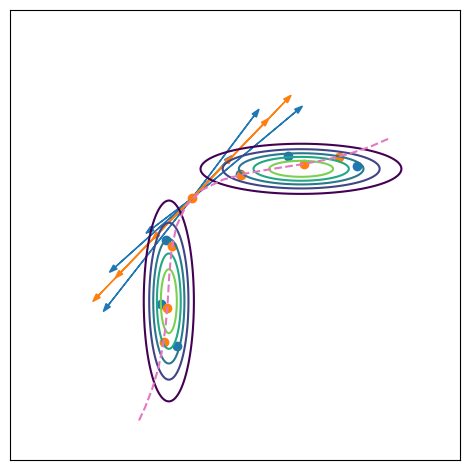

In [19]:
# plot tangent space approximations
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], l2_pga_solver_bary.log_x_data[i, 0], l2_pga_solver_bary.log_x_data[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], Xi_bary[i, 0], Xi_bary[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(exp_bary_Xi[:,0], exp_bary_Xi[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(mfld_fit[:,0], mfld_fit[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/l2-pga.eps")
plt.show()


In [20]:
print(((data - exp_bary_Xi)**2).mean(0).sum().sqrt() / ((data - bary)**2).mean(0).sum().sqrt())

tensor(0.1146)


### Isometrized Riemannian data analysis ###

In [21]:
iso_manifold = l2IsometrizedVectorEuclidean(manifold, num_intervals=100)

In [22]:
# compute geodesic
t = torch.linspace(0.,1.,20)

iso_geodesic = iso_manifold.geodesic(x0,y2,t).detach()

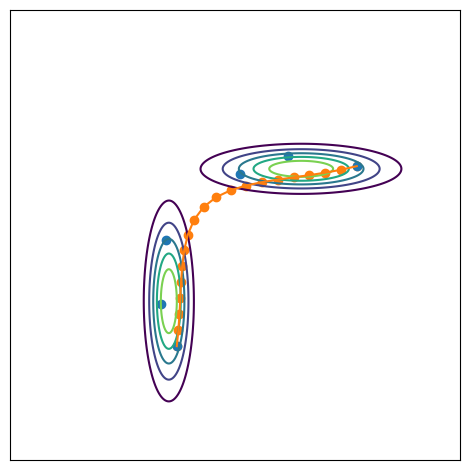

In [23]:
# plot geodesic
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.plot(iso_geodesic[:,0], iso_geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(iso_geodesic[:,0], iso_geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(data[:,0], data[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/iso-geodesic.eps")
plt.show()

In [24]:
# construct l2-pga solver
iso_l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data, iso_manifold, bary)

In [25]:
# compute low rank approximations
iso_Xi_bary, iso_exp_bary_Xi, _ = iso_l2_pga_solver_bary.solve(1) # compute rank 1 approximation

Computing rank 1 approximation on tangent space
Computing rank 1 approximation on euclidean space
Computing rank 1 errors


In [26]:
# compute learned manifold
iso_log_bary_endpoints = torch.stack([1.4 * Xi_bary[-1].norm() / iso_Xi_bary[-1].norm() * iso_Xi_bary[-1], 1.7 * Xi_bary[0].norm() / iso_Xi_bary[0].norm() * iso_Xi_bary[0]],dim=0)
iso_end_points = manifold.exp(bary, iso_log_bary_endpoints)
iso_mfld_fit = iso_manifold.geodesic(iso_end_points[0], iso_end_points[1], t).detach().cpu()
print(iso_end_points)

tensor([[ 0.6820,  0.4119],
        [-0.4415, -0.8317]], grad_fn=<DivBackward0>)


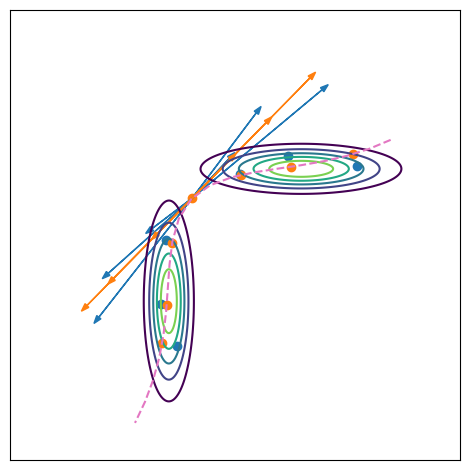

In [27]:
# plot tangent space approximations
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
for i in range(iso_l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], iso_l2_pga_solver_bary.log_x_data[i, 0], iso_l2_pga_solver_bary.log_x_data[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for i in range(iso_l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], iso_Xi_bary[i, 0], iso_Xi_bary[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(iso_exp_bary_Xi[:,0], iso_exp_bary_Xi[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(iso_mfld_fit[:,0], iso_mfld_fit[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/additive-tanh-isotropic-nflow-pullback/iso-l2-pga.eps")
plt.show()

In [28]:
print(((data - iso_exp_bary_Xi)**2).mean(0).sum().sqrt() / ((data - bary)**2).mean(0).sum().sqrt())

tensor(0.0868)


### Comparing naive and isometrized ###

In [29]:
# Compute geodesic relative rmse from the barycentre
squared_geo_errors = torch.zeros(data.shape[0])
dists = ((data - bary)**2).sum(1)
for i, x_i in enumerate(data):
    geodesic_i = manifold.geodesic(bary, x_i, t).detach().cpu()
    iso_geodesic_i = iso_manifold.geodesic(bary, x_i, t).detach().cpu()
    squared_geo_errors[i] = ((geodesic_i - iso_geodesic_i)**2).mean(0).sum()

geo_rel_rmse = (squared_geo_errors.mean() / dists.mean()).sqrt()
print(geo_rel_rmse)

tensor(0.0156)


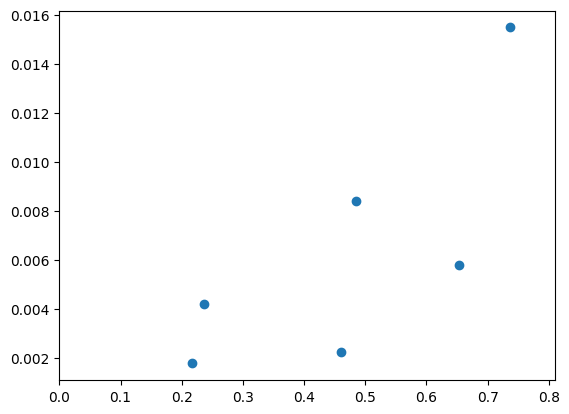

In [30]:
# Make scatter plot
plt.scatter(dists.sqrt(), squared_geo_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.show()

In [31]:
# Compute low rank relative rmse from the barycentre
squared_low_rank_errors = ((data - exp_bary_Xi)**2).sum(1)
low_rank_rel_rmse = (squared_low_rank_errors.mean() / dists.mean()).sqrt()

squared_low_rank_iso_errors = ((data - iso_exp_bary_Xi)**2).sum(1)
iso_low_rank_rel_rmse = (squared_low_rank_iso_errors.mean() / dists.mean()).sqrt()

print(low_rank_rel_rmse)
print(iso_low_rank_rel_rmse)

tensor(0.1146)
tensor(0.0868)


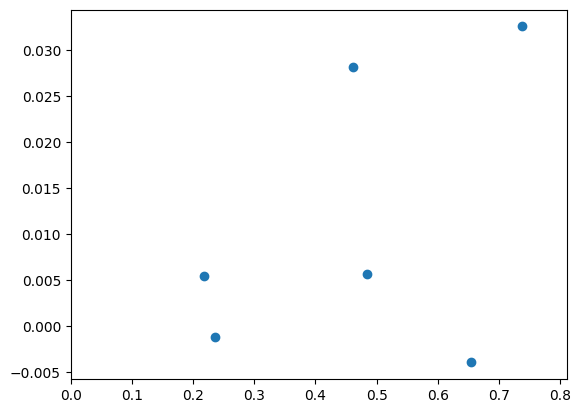

In [32]:
# Make scatter plot
plt.scatter(dists.sqrt(), squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.show()